<a href="https://colab.research.google.com/gist/pietronvll/bc0887f9822311c32b46aa2d803299c1/generator_spectra_1dlangevin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Defining Potential Function and computing Boltzmann probability density function

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import ml_confs
from scipy.integrate import romb, quad

# Using JAX as computing gradients (needed later) is super-easy
@jax.jit
def potential(X):
    """
    See Example 1 of "Modeling Molecular Kinetics with tICA and the Kernel Trick" 10.1021/ct5007357
    """

    #return 4*(x**8+ 0.8*jnp.exp(-80*(x**2)) +  0.2*jnp.exp(-80*((x - 0.5)**2)) + 0.5*jnp.exp(-40*((x + 0.5)**2)))
    #return 10 * x**2 * (0.5 *x**2 -1)
    if X.shape[0] !=2:
        x = X[:,0]
        y = X[:,1]
    else:
        x = X[0]
        y = X[1]
    #return 0.15*(-280*jnp.exp(-15*(x-1)**2-10*y**2) - 170*jnp.exp(-(x-0.2)**2-10*(y-0.5)**2) - 170*jnp.exp(-6.5*(0.5+x)**2+11*(x+0.5)*(y-1.5)-6.5*(y-1.5)**2)+15*jnp.exp(0.7*(1+x)**2+0.6*(1+x)*(y-1)+0.7*(y-1)**2))
    #return 0.15*(146.7-280*jnp.exp(-15*(x-1)**2-10*(y-0)**2)-170*jnp.exp(-1*(x-0.2)**2-10*(y-0.5)**2)-170*jnp.exp(-6.5*(x+0.5)**2+11*(x+0.5)*(y-1.5)-6.5*(y-1.5)**2)+15*jnp.exp(0.7*(x+1)**2+0.6*(x+1)*(y-1)+0.7*(y-1)**2))    
    return 0.15*(-200*jnp.exp(-(x-1)**2-10*y**2)-100*jnp.exp(-x**2-10*(y-0.5)**2)-170*jnp.exp(-6.5*(0.5+x)**2+11*(x+0.5)*(y-1.5)-6.5*(y-1.5)**2)+15*jnp.exp(0.7*(1+x)**2+0.6*(1+x)*(y-1)+0.7*(y-1)**2))

def return_analytical_forces(vec):
    x = vec[:,0]
    y = vec[:,1]
    forces_x = 0.15*(400*(x-1)*np.exp(-(x-1)**2-10*y**2)+200*x*np.exp(-x**2-10*(y-0.5)**2)-170*(-6.5*2*(0.5+x)+11*(y-1.5))*np.exp(-6.5*(0.5+x)**2+11*(x+0.5)*(y-1.5)-6.5*(y-1.5)**2)+15*(0.7*2*(x+1)+0.6*(y-1))*np.exp(0.7*(1+x)**2+0.6*(1+x)*(y-1)+0.7*(y-1)**2))
    forces_y = 0.15*(4000*np.exp(-(x-1)**2-10*y**2)+2000*(y-0.5)*np.exp(-x**2-10*(y-0.5)**2)-170*(11*(x+0.5)-6.5*2*(y-1.5))*np.exp(-6.5*(0.5+x)**2+11*(x+0.5)*(y-1.5)-6.5*(y-1.5)**2)+15*(0.6*(1+x) +0.7*2*(y-1))*np.exp(0.7*(1+x)**2+0.6*(1+x)*(y-1)+0.7*(y-1)**2))
    return np.concatenate((-forces_x[:,np.newaxis],-forces_y[:,np.newaxis]),axis=1)

configs = ml_confs.from_dict({"kBT": 1.0, "gamma": 10.0})

beta = configs["kBT"]**-1
grad_potential = jax.grad(potential)

In [2]:
from discretize import TensorMesh
from scipy.sparse import diags

domain_boundary = ((-1.8,1.9),(-1.0,2.5))
num_nodes = 2**6 + 1 #Odd number of nodes place a node at 0, Even number of nodes place a "center" at 0.

#width = (domain_boundary[1] - domain_boundary[0])/num_nodes
mesh = TensorMesh([(1.0+1.9)*np.ones(num_nodes)/num_nodes,(1.0+1.7)*np.ones(num_nodes)/num_nodes], origin=[-1.7,-0.5])#
mesh.set_cell_gradient_BC('dirichlet') #Dirichlet boundary condition as we expect that that the density is (virtually) 0 at the domain boundaries

grad_x = mesh.average_face_x_to_cell.dot(mesh.cell_gradient_x)
grad_y = mesh.average_face_y_to_cell.dot(mesh.cell_gradient_y)
lap_x = mesh.face_x_divergence.dot(mesh.cell_gradient_x)
lap_y = mesh.face_y_divergence.dot(mesh.cell_gradient_y)

#print(jax.vmap(grad_potential)(mesh.cell_centers))
grad_potential_discretized = np.asarray(jax.vmap(grad_potential)(mesh.cell_centers))
grad_potential_discretized_x = diags(grad_potential_discretized[:,0])
grad_potential_discretized_y = diags(grad_potential_discretized[:,1])


inv_gamma = configs.gamma**-1
kBT = configs.kBT
print(grad_x.shape)

# Eq.(31) of https://doi.org/10.1007/978-3-642-56589-2_9 recalling that \sigma^2/(\gamma*2) = kBT
generator = 0.5*inv_gamma*kBT*(lap_x+lap_y) - 0.5*inv_gamma * (grad_potential_discretized_x.dot(grad_x)+grad_potential_discretized_y.dot(grad_y)) #inv_gamma*grad_potential_discretized.dot(grad_x,axis=1)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


(4225, 4225)


In [3]:
generator_values, generator_vectors = np.linalg.eig(generator.toarray()) #Using the full decomposition here to ensure numerical consistency (might take a while)

In [4]:
sort_perm = np.argsort(-np.real(generator_values))
eigenvalues = generator_values[sort_perm]
eigenfunctions = generator_vectors[:, sort_perm]

In [5]:
eigenvalues.shape

(4225,)

In [6]:
np.real(-eigenvalues)[:10]

array([-6.35304173e-13,  5.26045379e-05,  1.76556821e-01,  6.21403537e-01,
        1.71755446e+00,  1.75350067e+00,  2.39250289e+00,  2.80587695e+00,
        2.83350102e+00,  3.27903424e+00])

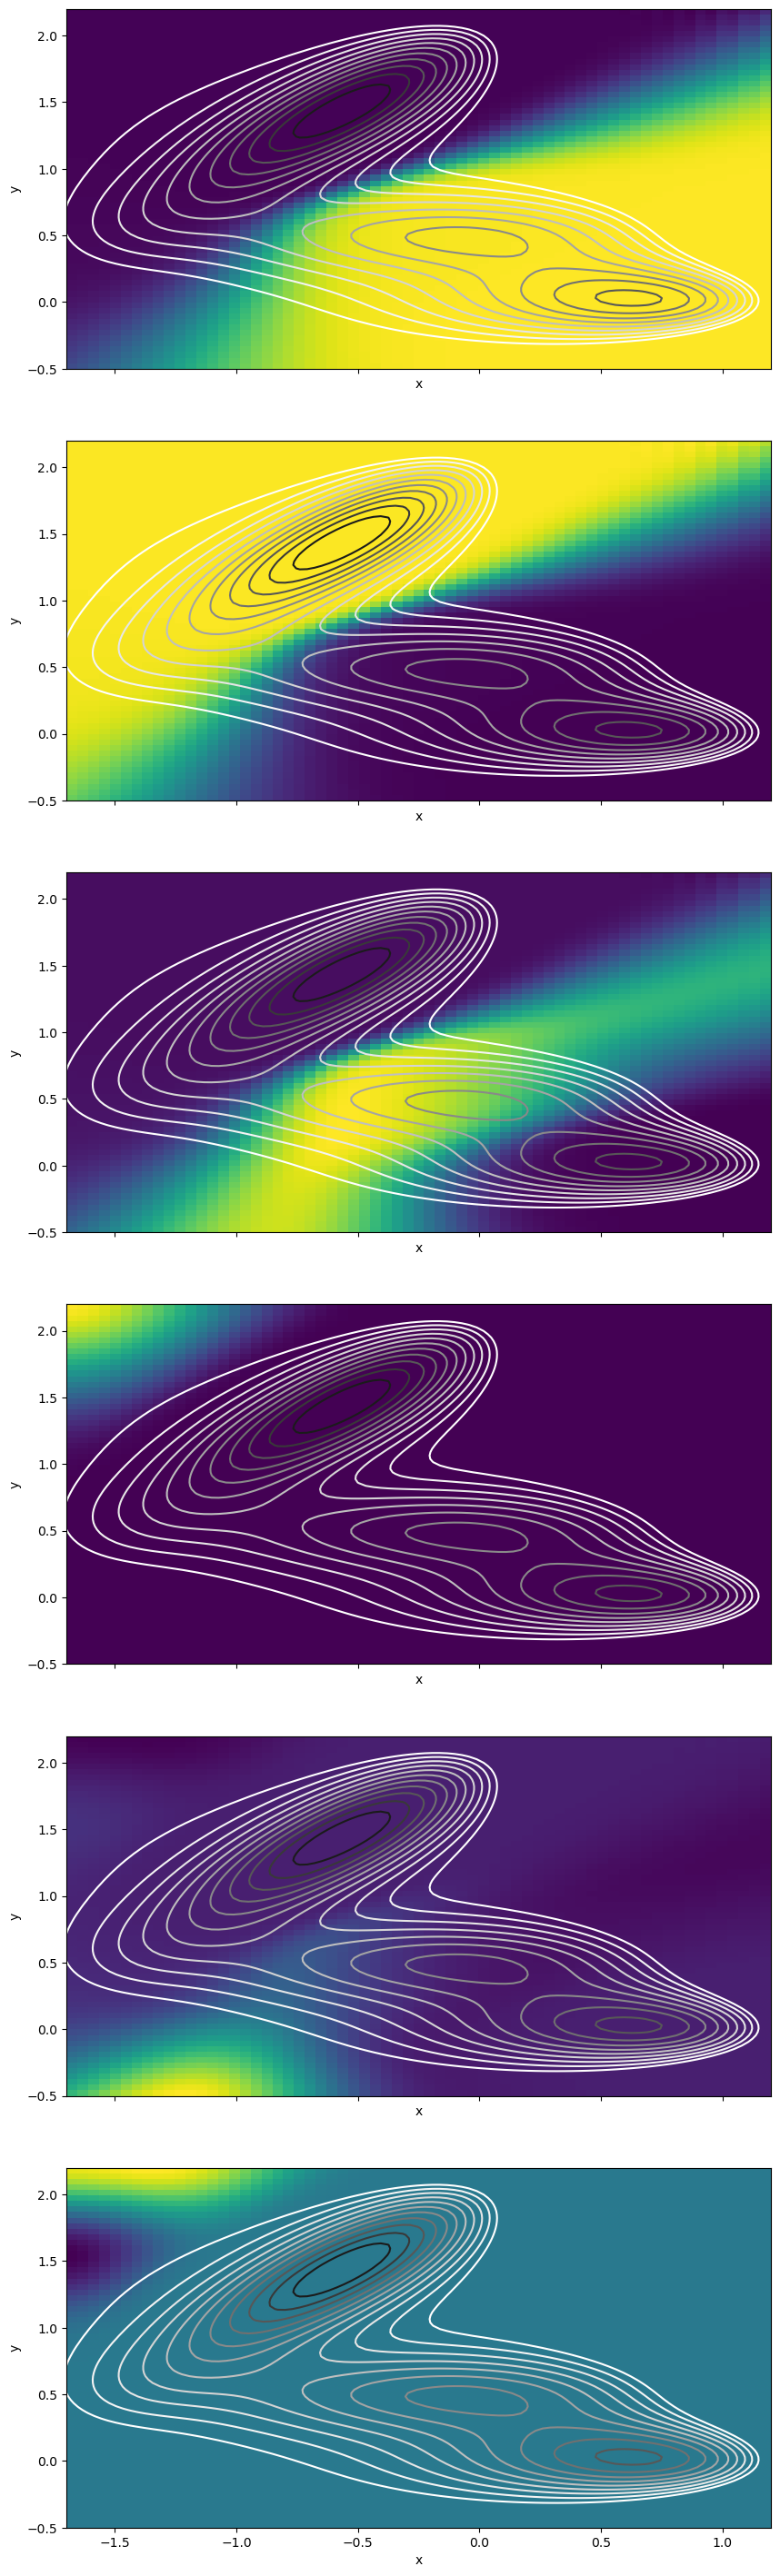

In [7]:

def muller_brown_potential(x, y):
    """Muller-Brown analytical potential"""
    prefactor = 0.15
    A = (-200, -100, -170, 15)
    a = (-1, -1, -6.5, 0.7)
    b = (0, 0, 11, 0.6)
    c = (-10, -10, -6.5, 0.7)
    x0 = (1, 0, -0.5, -1)
    y0 = (0, 0.5, 1.5, 1)
    offset = -146.7

    v = -prefactor * offset
    for i in range(4):
        v += (
            prefactor
            * A[i]
            * np.exp(
                a[i] * (x - x0[i]) ** 2
                + b[i] * (x - x0[i]) * (y - y0[i])
                + c[i] * (y - y0[i]) ** 2
            )
        )
    return v
def plot_isolines_2D(
    function,
    component=None,
    limits=((-1.8, 1.2), (-0.4, 2.1)),
    num_points=(100, 100),
    mode="contourf",
    levels=12,
    cmap=None,
    colorbar=None,
    max_value=None,
    ax=None,
    **kwargs,
):
    """Plot isolines of a function/model in a 2D space."""

    # Define grid where to evaluate function
    if type(num_points) == int:
        num_points = (num_points, num_points)
    xx = np.linspace(limits[0][0], limits[0][1], num_points[0])
    yy = np.linspace(limits[1][0], limits[1][1], num_points[1])
    xv, yv = np.meshgrid(xx, yy)



    z = function(xv, yv)

    if max_value is not None:
        z[z > max_value] = max_value

    # Setup plot
    return_axs = False
    if ax is None:
        return_axs = True
        _, ax = plt.subplots(figsize=(6, 4.0), dpi=100)

    # Color scheme
    if cmap is None:
        if mode == "contourf":
            cmap = "fessa"
        elif mode == "contour":
            cmap = "Greys_r"

    # Colorbar
    if colorbar is None:
        if mode == "contourf":
            colorbar = True
        elif mode == "contour":
            colorbar = False

    # Plot
    if mode == "contourf":
        pp = ax.contourf(xv, yv, z, levels=levels, cmap=cmap, **kwargs)
        if colorbar:
            plt.colorbar(pp, ax=ax)
    else:
        pp = ax.contour(xv, yv, z, levels=levels, cmap=cmap, **kwargs)

    if return_axs:
        return ax
    else:
        return None

num_to_plot = 6
fig, axes = plt.subplots(nrows = num_to_plot, sharex=True, figsize = (10, 6*num_to_plot))
for idx in range(num_to_plot):
  ax = axes[idx]
  efun = eigenfunctions[:, idx].real
  #ax.scatter(mesh.cell_centers[:,0],mesh.cell_centers[:,1], c=efun,cmap="viridis")
  mesh.plot_image(efun,ax=ax,levels=50,cmap='RdGy')
  plot_isolines_2D(muller_brown_potential,levels=np.linspace(0,24,12),mode='contour',ax=ax)
  #fig.colorbar( ax=ax, orientation='vertical')

  #ax.axhline(y=0, linestyle='--', alpha = 0.5)
  #ax.text(x=-0.99, y=1.3, s=f'Eigenfunction $\psi_{idx + 1}$\nEigenvalue $\lambda_{idx + 1} = {eigenvalues[idx].real:.2f}$ ')
  #ax.set_xlim(-1, 1)
  #ax.set_ylim(-2, 2)